# Single Cell RNA-Seq

In this tutorial we are going to run through how UCDeconvolve can be used to aid in the analysis and annotation of
single-cell RNA-Sequencing data. For this tutorial, we are going to use the 'pbmc3k' dataset provided in the scanpy
datasets model at ``sc.datasets.pbmc3k()``. 

## Loading Packages & Authenticating
The first step in this analysis will be to load scanpy and ucdeconvolve after following the installation and registration instructions, and
authenticate our API. In this tutorial we saved our user access token in the variable ``TOKEN``.

In [80]:
import scanpy as sc
import ucdeconvolve as ucd

ucd.api.authenticate(TOKEN)

2023-04-25 15:57:57,357|[UCD]|INFO: Updated valid user access token.


%%eval-rst
|
.. note::
   By default the logging level is set to ``DEBUG``. To change logging levels you can import ``logging`` and set
   ``ucd.settings.verbosity`` directly. To reduce logs, change ``verbosity`` to ``logging.INFO``. In general we
   recommend keeping logging to ``DEBUG`` to provide status updates on a running deconvolution job.

## Loading & Preprocessing Data
We will now begin by loading our pbmc dataset.

In [3]:
adata = sc.datasets.pbmc3k()

We will save raw counts data into adata, which can serve as an input to ucd functions. Unicell will detect non-logarithmized
counts data and automatically normalize our data. We will run a quick built-in preprocssing functions using scanpy to
obtain some clustered data. This step will take a minute or two to complete.

In [ ]:
adata.raw = adata

sc.pp.recipe_seurat(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors = 30)
sc.tl.umap(adata, min_dist = 0.1)
sc.tl.leiden(adata, resolution = 0.75)

We plot the UMAP of our dataset using leiden clusters as an overlay and see the following image:

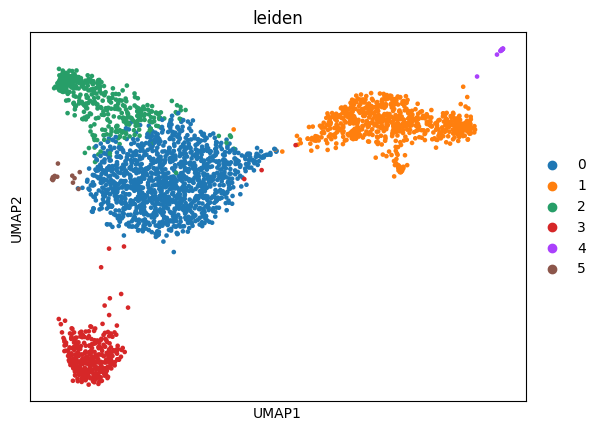

In [29]:
sc.pl.umap(adata, color = 'leiden')

## Initial Cluster Identification Using UCDBase 
To get a general sense of the celltypes most likely present in this dataset, we want to first run ``ucd.tl.base`` which
will return context-free deconvolutions of cell type states.

In [7]:
ucd.tl.base(adata)

2023-04-25 13:10:28,425|[UCD]|INFO: Starting UCDeconvolveBASE Run. | Timer Started.
Preprocessing Dataset | 100% (11 of 11) || Elapsed Time: 0:00:01 Time:  0:00:01
2023-04-25 13:10:30,501|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 13:10:31,339|[UCD]|INFO: Upload Complete | Elapsed Time: 0.838 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | / |#| 0 Elapsed Time: 0:00:00
Waiting For Submission : QUEUED | Queue Size : 1 | | |#| 3 Elapsed Time: 0:00:04
Waiting For Submission : RUNNING | Queue Size : 1 | / |#| 3 Elapsed Time: 0:00:04
Waiting For Completion | 100% (2700 of 2700) || Elapsed Time: 0:00:28 Time:  0:00:28
2023-04-25 13:11:07,163|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 13:11:08,505|[UCD]|INFO: Download Complete | Elapsed Time: 1.342 (s)
2023-04-25 13:11:09,238|[UCD]|INFO: Run Complete | Elapsed Time: 40.812 (s)


### Plotting Clustermap
To get a general sense of the deconvolution results, let's plot a clustermap that aggregates base predictions on the basis
of leiden cluster using the function ``ucd.pl.base_clustermap``

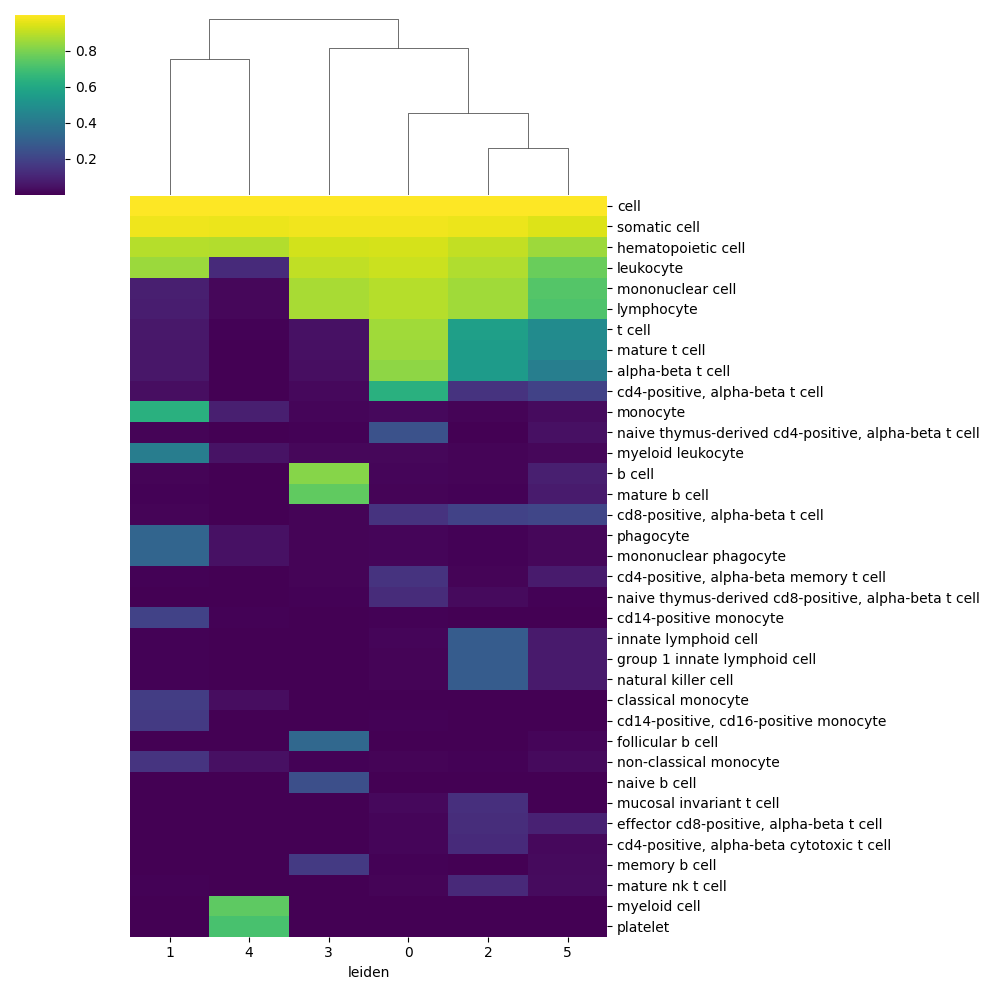

In [58]:
ucd.pl.base_clustermap(adata, groupby = 'leiden', n_top_celltypes=75)

We can see that the predictions shown in the clustermap are hierarchecal. By default, ucdeconvolve base performs belief propagation, which takes flattened predictions and aggregates them up a cell type heirarchy. This flag can be set in the ``ucd.tl.base`` function as ``propagate = False``. For most cases we reccomend peforming belief propagation, as it accounts for uncertainty in ground-truth labels used during training. 

In either case, we can use this clustering information to label our dataset by selecting the most likely detailed cell subtype, using ucdbase to guide us to an answer faster than performing manual curation.

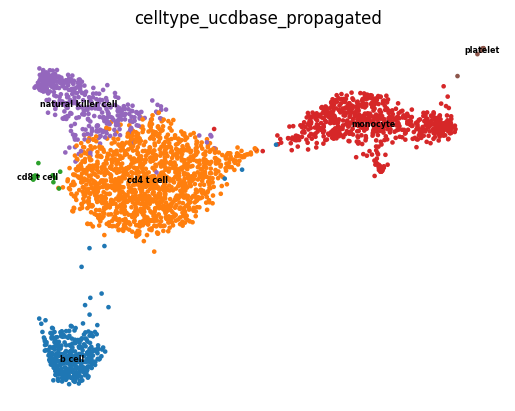

In [59]:
label = "celltype_ucdbase_propagated"
adata.obs[label] = 'unknown'
adata.obs.loc[adata.obs.leiden.isin(("1",)), label] = "monocyte"
adata.obs.loc[adata.obs.leiden.isin(("4",)), label] = "platelet"
adata.obs.loc[adata.obs.leiden.isin(("3",)), label] = "b cell"
adata.obs.loc[adata.obs.leiden.isin(("0",)), label] = "cd4 t cell"
adata.obs.loc[adata.obs.leiden.isin(("2",)), label] = "natural killer cell"
adata.obs.loc[adata.obs.leiden.isin(("5",)), label] = "cd8 t cell"

sc.pl.umap(adata, color = 'celltype_ucdbase_propagated', legend_loc = 'on data',
           legend_fontsize = "xx-small", frameon = False)

## Examining Feature Attributions with UCDExplain
To gain some additional insight into the cell types being predicted for each cluster, we can leveraged **integrated gradients**
which is implemented in the ``ucd.tl.explain`` module. This method takes a target output for the ucdbase model and computes
attribution scores for all input genes. A positive attribution score indicates that a given gene's expression is positively
associated with the prediction of that given cell type (i.e. canonical marker genes tend to have high feature attribution scores
for their corresponding cell types) while a negative attribution score indicates that a given gene's expression is negatively
associated with the prediction of that given cell type (i.e. it may be a canonical marker of another cell type). We can use
feature attributions to validate some of our predictions by confirming that the top genes associated with a given cell type
are concordant with biological phenomena. 

### Examining Raw Predictions
To do this, we first must examine the models raw, non-propagated predictiosn. As feature attributions using integrated gradients
relies on the core wieghts underpinning the ucdbase deep learning model, it does not consider belief propagation which is a post-processing
function. Therefore, we ned to first get a sense of the "raw" cell type predictions made for each cluster.

We can plot raw cell type predictions using the same clustermap function above, but this time adding an additional parameter.


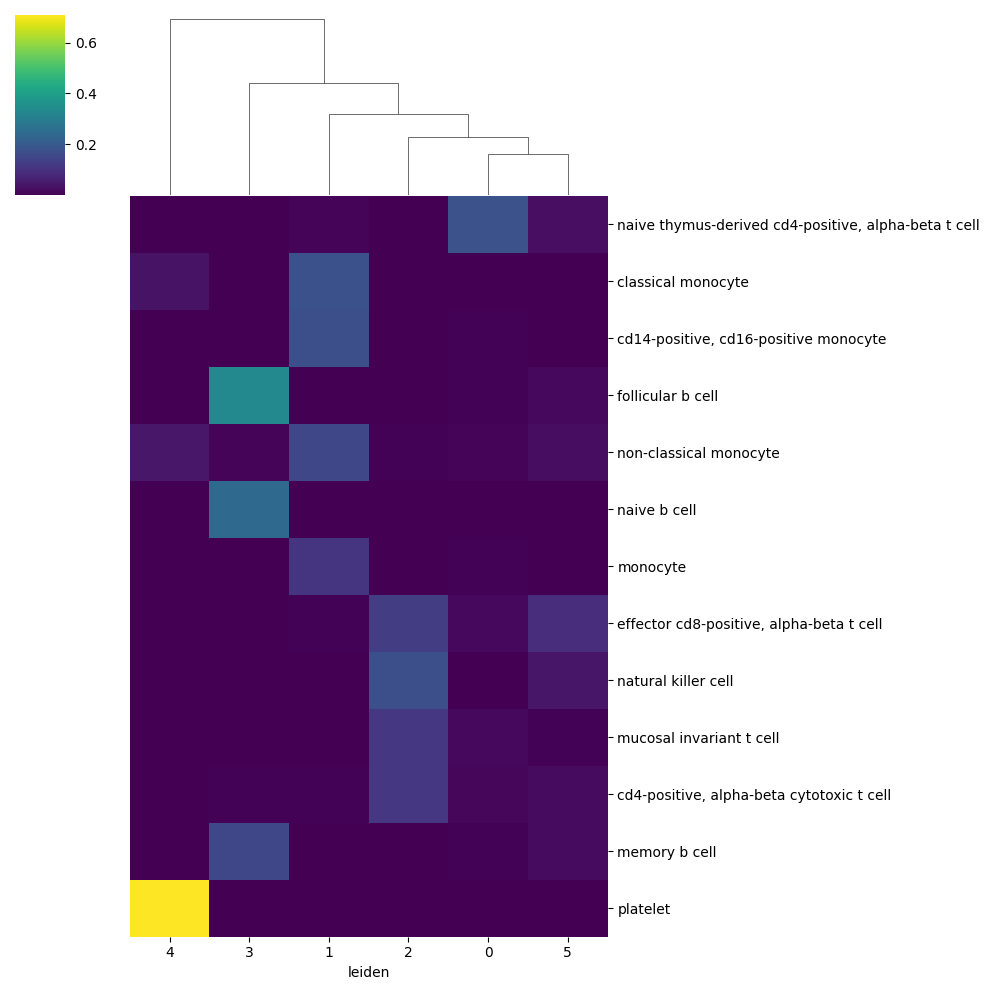

In [60]:
ucd.pl.base_clustermap(adata, groupby = 'leiden', category = 'raw', n_top_celltypes = 75)

We can immediately see that these predictions are alot more specific for each cluster. We include a utility function to assign
target cell types from predictions to each cluster, and can use this 'raw' prediction information to collect feature attributions
for each cluster individually. This functions creates a new column in ``adata.obs`` entitled ``pred_celltype_{key}`` which in our case
key, which represents the name of the run call, defaults to ``ucdbase``, therefore our column is called ``pred_celltype_ucdbase``.

In [61]:
ucd.utils.assign_top_celltypes(adata, category = "raw", groupby = "leiden")

Let's plot the resulting 'raw' assigned celltypes over our UMAP and compre them
with our aggregated propagation assignments we performed semi-manually.

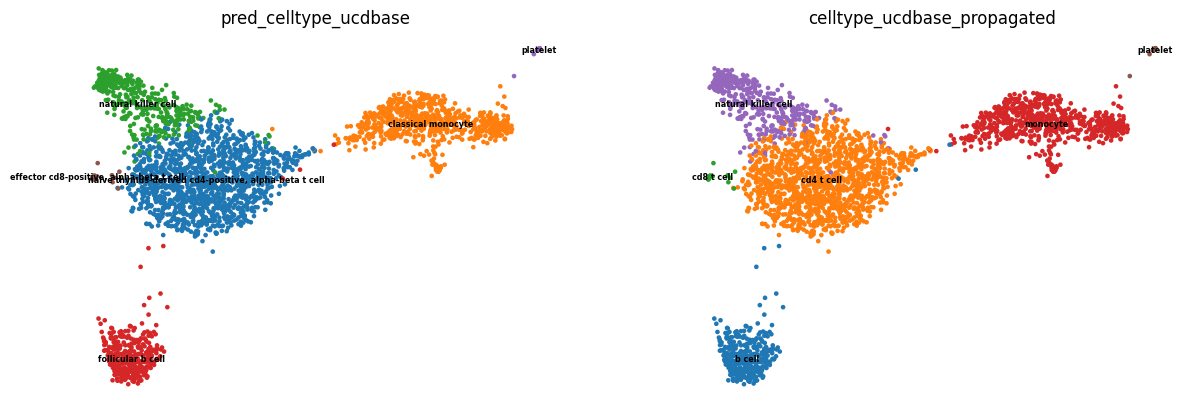

In [62]:
sc.pl.umap(adata, color = ["pred_celltype_ucdbase", "celltype_ucdbase_propagated"],
           legend_loc = 'on data', legend_fontsize = 'xx-small', frameon = False)

### Running UCDExplain

%%eval-rst
.. warning::
   As feature attributions is a highly computationally intensive operation, for scRNA-Seq data where each cell
   is considered a sample, we **highly recommend utilizing the subsampling capabilities** built into ``ucd.tl.explain``
   to speed up peformance. When run at the cluster-level, we find that subsampling a sufficient number of cells from
   each cluster provides the same level of feature attribution granularity as one would gain running all cells.

Let's start by retrieving a dictionary mapping our groups in ``leiden`` to our
raw celltypes. The ``assign_top_celltypes`` function has a parameter that can be
set ``inplace = False`` which will return the dictionary directly.

In [63]:
celltypes = ucd.utils.assign_top_celltypes(adata, category = "raw", groupby = "leiden", inplace = False)

Now let's go ahead and run ``ucd.tl.explain` withour group set to ``leiden``. We will take as many as 64 cells per
group to subsample with.

In [37]:
ucd.tl.explain(adata, celltypes = celltypes, groupby = "leiden", group_n = 64)

2023-04-25 14:52:06,134|[UCD]|INFO: Starting UCDeconvolveEXPLAIN Run. | Timer Started.
Preprocessing Dataset | 100% (2 of 2) |##| Elapsed Time: 0:00:00 Time:  0:00:00
2023-04-25 14:52:06,884|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 14:52:07,714|[UCD]|INFO: Upload Complete | Elapsed Time: 0.829 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | / |#| 0 Elapsed Time: 0:00:00
Waiting For Submission : QUEUED | Queue Size : 1 | - |#| 1 Elapsed Time: 0:00:01
Waiting For Submission : RUNNING | Queue Size : 1 | \ |#| 1 Elapsed Time: 0:00:01
Waiting For Completion | 100% (283 of 283) || Elapsed Time: 0:00:57 Time:  0:00:57
2023-04-25 14:53:09,083|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 14:53:09,311|[UCD]|INFO: Download Complete | Elapsed Time: 0.227 (s)
2023-04-25 14:53:09,932|[UCD]|INFO: Run Complete | Elapsed Time: 63.798 (s)


Let's get a sense of the marker genes being used to classify each of the cell types. We can quickly obtain a decent visualization using the ``ucd.pl.explain_clustermap`` function.

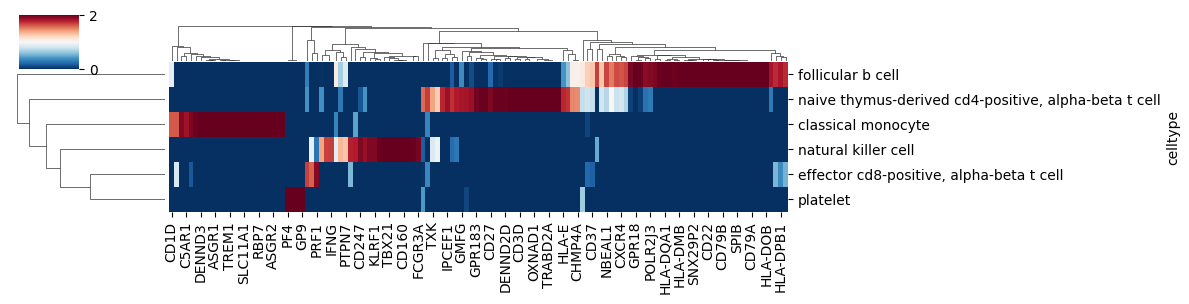

In [73]:
ucd.pl.explain_clustermap(adata, n_top_genes= 128)

We can see from these results that UCDbase associates specific gene sets with a particular cell type annotations. They can also be used to verify the annotations being given by UCD by comparing them with known marker genes for varius cell types. For example we see *CD79B* as a strong attribution towards follicular b cell annotation, which is a well known b cell marker.

We can also plot boxplots for each celltype showing only the top N feature attributions for each type using the ``ucd.pl.explain_boxplot`` function.

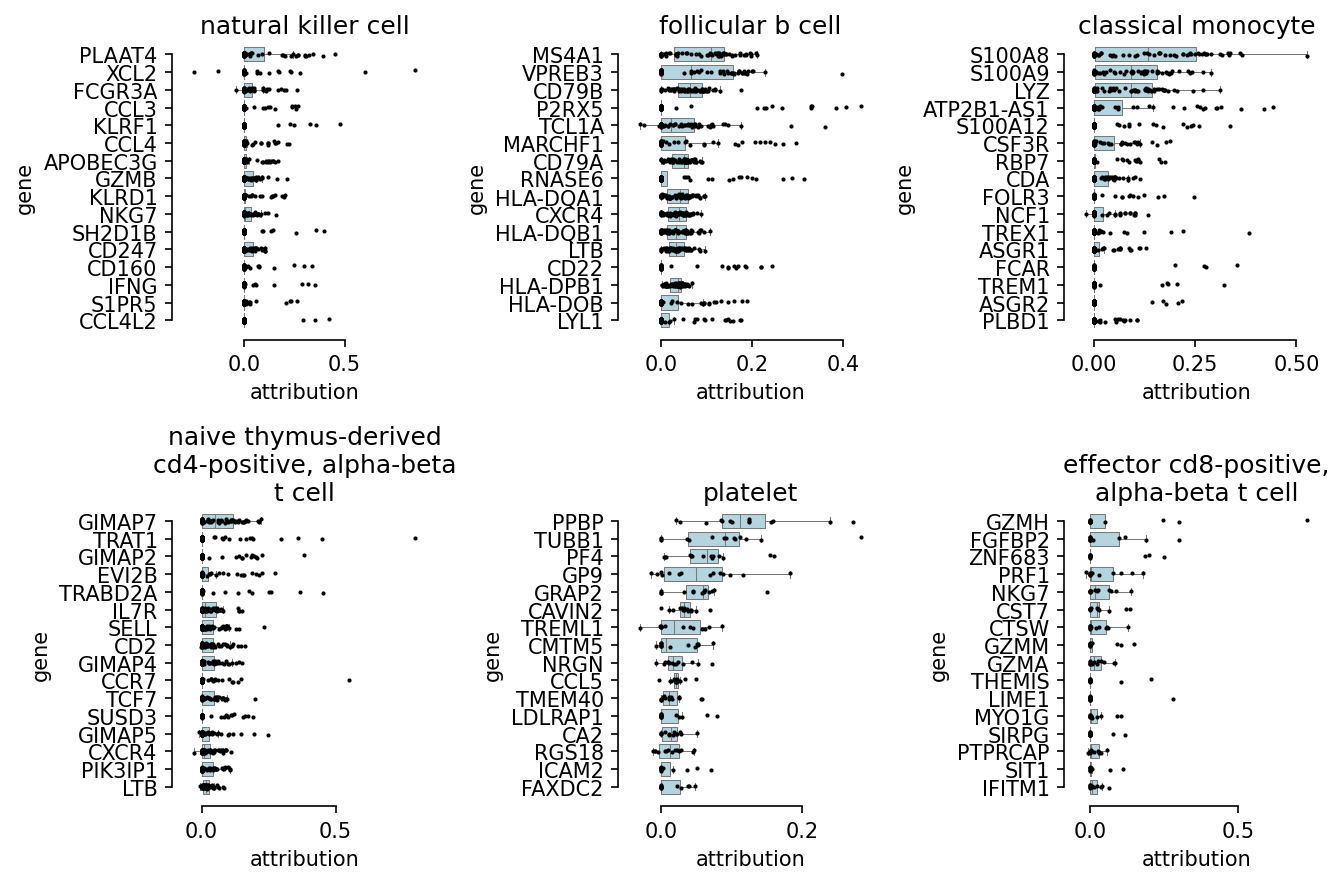

In [82]:
ucd.pl.explain_boxplot(adata, key = "ucdexplain", n_top_genes = 16, ncols = 3)


#### Compare Attribution Signatures for Different B Cell Subtypes
Something to note was that for our b cell cluster, the ucd raw annotations showed a distribution of probabilities across
three differen subtypes, 'follicular b cells', 'naive b cell', and 'memory b cell'. Let's generate explanations for all
three cell types and compare results. 

%%eval-rst
.. note::
    At this moment, ucdeconvolve only supports passing one cell type per feature attribution
    call per sample, so we will simply repeat the function call and append different key batches as results. In the future
    it will be possible to request predictions for multiple celltypes at once per sample. In the meantime, the plotting
    function ``ucd.pl.explain_clustermap`` supports viewing multiple keys simultaneously by passing a list of keys
    corresponding to different ucdexplain runs, presumably for different cell types.

In [65]:
adata_bcells = adata[adata.obs.leiden.eq("3")]

In [ ]:
ucd.tl.explain(adata_bcells, celltypes = 'naive b cell', key_added="ucdexplain_naive_b")
ucd.tl.explain(adata_bcells, celltypes = 'memory b cell', key_added="ucdexplain_memory_b")
ucd.tl.explain(adata_bcells, celltypes = 'follicular b cell', key_added="ucdexplain_follicular_b")

Now let's go ahead and plot to view which genes are being used to drive different subtype predictions. These
gene sets may be useful downstream in developing scoring signature or can be used for other applications such as gene set enrichment analysis or determining more fine-grained subclusters.

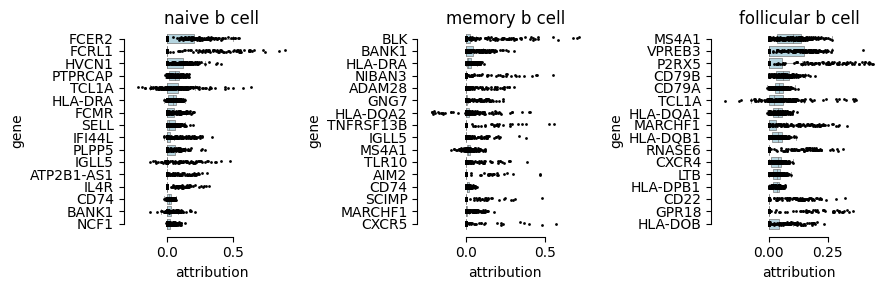

In [76]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols = 3, figsize = (9,3))

ucd.pl.explain_boxplot(adata_bcells, key = "ucdexplain_naive_b", ax = axes[0])
ucd.pl.explain_boxplot(adata_bcells, key = "ucdexplain_memory_b", ax = axes[1])
ucd.pl.explain_boxplot(adata_bcells, key = "ucdexplain_follicular_b", ax = axes[2])

## Generating Contextualized Predictions with UCDSelect
Once we obtain a general overview of our dataset and understand what cell type categories different clusters belong to, we
may want to perform higher-resolution, contextualized annotation. We can use UCDSelect to do this, which leverages
a transfer learning regime utilizing UCDBase as a feature extraciton engine to calculate cell-type features for an input
target dataset and an annotated reference dataset. 

UCDSelect comes with pre-built reference datasets for common tissue types. To view datasets available as prebuilt
references, run the utility function ``ucd.utils.list_prebuilt_references()``. 





%%eval-rst
.. note::
    Would you like to have a particular study incorporated as a prebuilt reference? Email us at ``ucdeconvolve@gmail.com``
    and let us know!

In [83]:
ucd.utils.list_prebuilt_references()

['allen-mouse-cortex', 'enge2017-human-pancreas', 'lee-human-pbmc-covid']

### Running UCDSelect
Let's go ahead and run ucdselect using the *lee-human-pbmc-covid* reference, as both our target and this reference
are PBMCs. 

In [85]:
ucd.tl.select(adata, "lee-human-pbmc-covid")

2023-04-25 16:05:15,042|[UCD]|INFO: Starting UCDeconvolveSELECT Run. | Timer Started.
Preprocessing Mix | 100% (11 of 11) |####| Elapsed Time: 0:00:01 Time:  0:00:01
Preprocessing Ref | 100% (1 of 1) |######| Elapsed Time: 0:00:00 Time:  0:00:00
2023-04-25 16:05:18,864|[UCD]|INFO: Uploading Data | Timer Started.
2023-04-25 16:05:19,885|[UCD]|INFO: Upload Complete | Elapsed Time: 1.021 (s)
Waiting For Submission : UNKNOWN | Queue Size : 0 | \ |#| 2 Elapsed Time: 0:00:03
Waiting For Submission : QUEUED | Queue Size : 1 | | |#| 3 Elapsed Time: 0:00:04
Waiting For Submission : RUNNING | Queue Size : 1 | | |#| 3 Elapsed Time: 0:00:04
Waiting For Completion | 100% (2700 of 2700) || Elapsed Time: 0:00:54 Time:  0:00:54
2023-04-25 16:06:52,212|[UCD]|INFO: Download Results | Timer Started.
2023-04-25 16:06:52,779|[UCD]|INFO: Download Complete | Elapsed Time: 0.566 (s)
2023-04-25 16:06:53,483|[UCD]|INFO: Run Complete | Elapsed Time: 98.44 (s)


Now let's go ahead and assign these predictions to our cells. We will use a similar approach as we did with
ucdbase, but this time we pass "ucdselect" as our results key to indicate this is the run we want to assign from. Additionally,
we are going to increase our clustering resolution as we are working with a contextualized, high-resolution reference dataset.

%%eval-rst
.. note::
    Cell types are best regarded as phenotypic "states" and as such exhibit a spectrum of variation. Assigning on the basis
    of a cluster ID represents an approximation that serves to reduces noise in annotations. Care should be taken when
    selecting a degree of clustering to use for cell type assignment.

In [129]:
sc.tl.leiden(adata, resolution=3.0, key_added="leiden_hires")
ucd.utils.assign_top_celltypes(adata, "ucdselect", groupby = "leiden_hires")

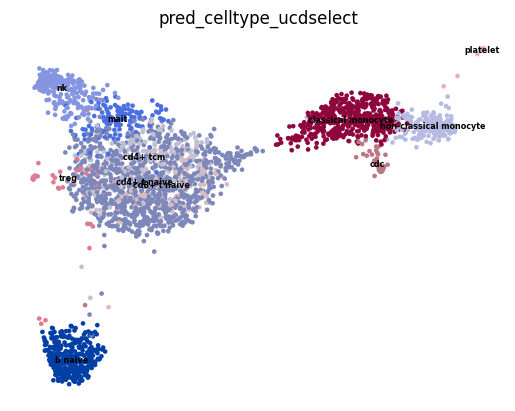

In [131]:
sc.pl.umap(adata, color = "pred_celltype_ucdselect", legend_loc = 'on data',
           legend_fontsize = 'xx-small', frameon = False)